# Egg segm. from centre with GraphCut

In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
import pandas as pd
from PIL import Image
# from scipy import spatial, ndimage
from skimage import segmentation as sk_segm
import matplotlib.pylab as plt

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_io
import segmentation.superpixels as tl_spx
import segmentation.region_growing as tl_rg

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Loading ovary

In [3]:
COLORS = 'bgrmyck'
PATH_IMAGES = tl_io.update_path(os.path.join('images', 'drosophila_ovary_slice'), absolute=True)
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*'))])
dir_img = os.path.join(PATH_IMAGES, 'image')
dir_segm = os.path.join(PATH_IMAGES, 'segm')
dir_annot = os.path.join(PATH_IMAGES, 'annot_eggs')
dir_center = os.path.join(PATH_IMAGES, 'annot_eggs')

['annot_eggs', 'annot_struct', 'center_levels', 'egg_ray_shapes.csv', 'images', 'list_ovary-2d_imgs-center.csv', 'list_ovary-2d_imgs-center_datagrid-Matlab.csv', 'list_ovary-2d_imgs-center_datagrid-Python.csv', 'list_ovary-2d_imgs-center_datagrid-Python.xls', 'list_ovary-2d_imgs-center_dropbox.csv', 'RG2SP_multi-model_mixture.pkl', 'RG2SP_single-model_mixture.pkl', 'segm', 'segm_rgb']


### Loading...

In [4]:
name = 'insitu7545'
img = np.array(Image.open(os.path.join(dir_img, name + '.jpg')))
seg = np.array(Image.open(os.path.join(dir_segm, name + '.png')))
centers = pd.DataFrame.from_csv(os.path.join(dir_center, name + '.csv')).values
centers[:, [0, 1]] = centers[:, [1, 0]]
FIG_SIZE = (12. * np.array(img.shape[:2]) / np.max(img.shape))

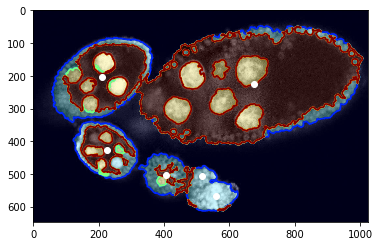

In [5]:
# plt.figure(figsize=FIG_SIZE)
plt.imshow(1. - img[:, :, 0], cmap=plt.cm.Greys)
plt.imshow(seg, alpha=0.2, cmap=plt.cm.jet), plt.contour(seg, cmap=plt.cm.jet)
_= plt.plot(centers[:, 1], centers[:, 0], 'ow')

### Superpixels

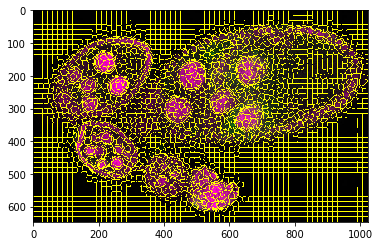

In [7]:
slic = tl_spx.segment_slic_img2d(img, sp_size=15, rltv_compact=0.35)
_= plt.imshow(sk_segm.mark_boundaries(img, slic))

## Obejct segmentation on pixel level

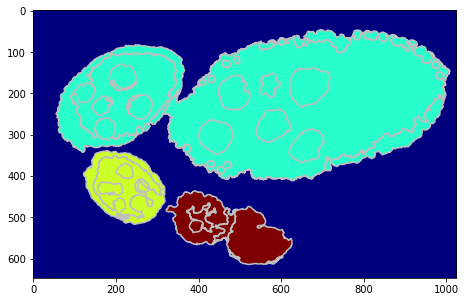

In [8]:
dict_debug_imgs = dict()
segm_obj = tl_rg.object_segmentation_graphcut_pixels(seg, centers, labels_fg_prob, gc_regul=1., 
                                                     seed_size=10, dict_debug_imgs=dict_debug_imgs)
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

(7, 647, 1024) [0 1 2 3 4 5 6]


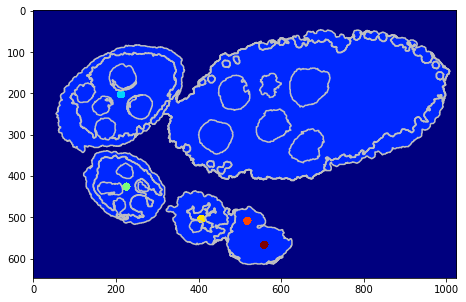

In [9]:
unary = np.array([u.tolist() for u in dict_debug_imgs['unary_imgs']])
print (unary.shape, np.unique(np.argmin(unary, axis=0)))
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(np.argmin(unary, axis=0), cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

## Obejct segmentation [pixel] with a shape prior

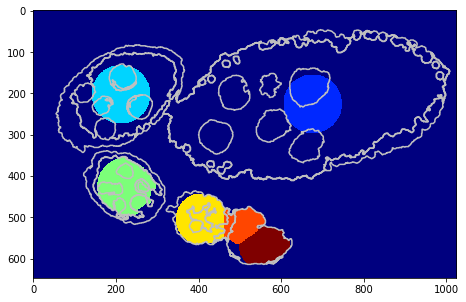

In [10]:
dict_debug_imgs = dict()
segm_obj = tl_rg.object_segmentation_graphcut_pixels(seg, centers, labels_fg_prob, gc_regul=2., seed_size=10, 
                                                     coef_shape=3, shape_mean_std=(50., 10.), dict_debug_imgs=dict_debug_imgs)
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

(7, 647, 1024) 

[0 1 2 3 4 5 6]


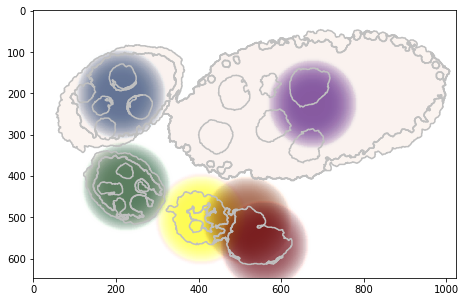

In [11]:
unary = np.array([u.tolist() for u in dict_debug_imgs['unary_imgs']])
print (unary.shape, np.unique(np.argmin(unary, axis=0)))
fig = plt.figure(figsize=FIG_SIZE)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
CMAPS = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.autumn, plt.cm.Oranges, plt.cm.Reds]
for i in range(1, len(unary)):
    im = 1 - (unary[i, :, :] / np.max(unary[i, :, :]))
    im = (im * 1000).astype(int)
    lut = CMAPS[i](range(1001))
    lut[:, 3] = np.linspace(0, 0.7, 1001)
    plt.imshow(lut[im], alpha=1)

## Obejct segmentation on SLIC level

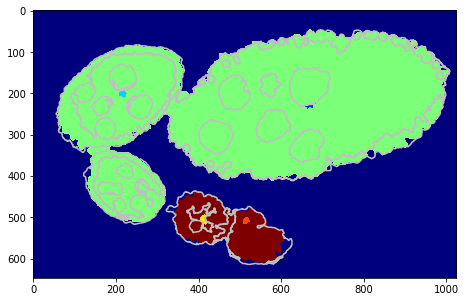

In [12]:
dict_debug_imgs = dict()
gc_labels = tl_rg.object_segmentation_graphcut_slic(slic, seg, centers, labels_fg_prob, gc_regul=2., edge_coef=1., 
                                                    edge_type='ones', add_neighbours=True, dict_debug_imgs=dict_debug_imgs)
segm_obj = np.array(gc_labels)[slic]

fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

(7, 647, 1024) 

[0 1 2 3 4 5 6]


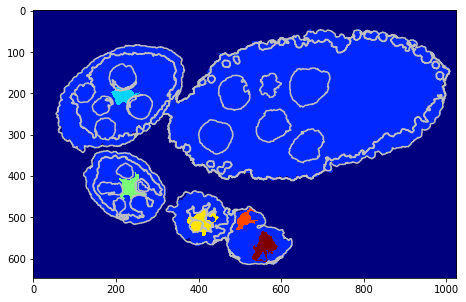

In [13]:
unary = np.array([u.tolist() for u in dict_debug_imgs['unary_imgs']])
print (unary.shape, np.unique(np.argmin(unary, axis=0)))
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(np.argmin(unary, axis=0), cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

## Obejct segmentation [SLIC] with a shape prior

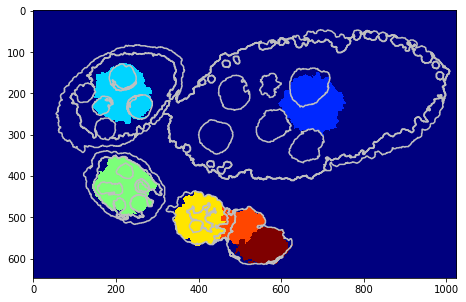

In [14]:
dict_debug_imgs = dict()
gc_labels = tl_rg.object_segmentation_graphcut_slic(slic, seg, centers, labels_fg_prob, gc_regul=1., edge_coef=1., 
                                                    edge_type='ones', coef_shape=3., shape_mean_std=(50., 10.), dict_debug_imgs=dict_debug_imgs)
segm_obj = np.array(gc_labels)[slic]
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

(7, 647, 1024) 

[0 1 2 3 4 5 6]


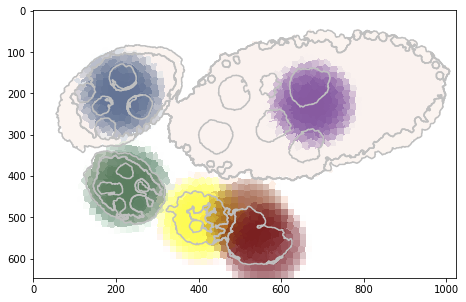

In [16]:
unary = np.array([u.tolist() for u in dict_debug_imgs['unary_imgs']])
print (unary.shape, np.unique(np.argmin(unary, axis=0)))
fig = plt.figure(figsize=FIG_SIZE)
plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
CMAPS = [plt.cm.Greys, plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.autumn, plt.cm.Oranges, plt.cm.Reds]
for i in range(1, len(unary)):
    im = 1 - (unary[i, :, :] / np.max(unary[i, :, :]))
    im = (im * 1000).astype(int)
    lut = CMAPS[i](range(1001))
    lut[:, 3] = np.linspace(0, 0.7, 1001)
    plt.imshow(lut[im], alpha=1)